In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Cluster Center Computation

In [ ]:
def compute_centroids(U_matrix, data, num_clusters, fuzziness):
    """
    Compute cluster centroids based on current membership matrix.
    """
    centers = np.zeros(num_clusters)

    for c in range(num_clusters):
        # weights for cluster c
        w = U_matrix[:, c] ** fuzziness

        # weighted average formula for centroid
        centers[c] = np.sum(w * data) / np.sum(w)

    return centers


Membership Matrix Update

In [ ]:
def refresh_memberships(U_matrix, data, centers, num_clusters, fuzziness):
    """
    Update the membership values using the standard FCM formula.
    """
    expo = 2.0 / (fuzziness - 1)

    for idx in range(len(data)):
        for c in range(num_clusters):

            dist_j = abs(data[idx] - centers[c])  # distance to cluster c

            if dist_j == 0:
                U_matrix[idx, :] = 0
                U_matrix[idx, c] = 1
                continue

            denominator = 0
            for ck in range(num_clusters):
                dist_k = abs(data[idx] - centers[ck])

                # Avoid divide-by-zero
                if dist_k == 0:
                    ratio = np.inf
                else:
                    ratio = (dist_j / dist_k) ** expo

                denominator += ratio

            U_matrix[idx, c] = 1.0 / denominator

    return U_matrix


Main FCM Algorithm

In [ ]:
def fuzzy_c_means(data, U_init, num_clusters, fuzziness=2, max_steps=100, epsilon=1e-4):
    """
    Main iterative FCM routine: update centers and memberships until convergence.
    """
    U_current = U_init.copy()

    for step in range(max_steps):

        prev_U = U_current.copy()

        # 1. Compute new centroids
        centroids = compute_centroids(U_current, data, num_clusters, fuzziness)

        # 2. Update membership values
        U_current = refresh_memberships(U_current, data, centroids, num_clusters, fuzziness)

        # 3. Check stopping condition
        diff = np.max(np.abs(U_current - prev_U))

        if diff < epsilon:
            print(f"Algorithm converged at iteration {step}")
            break

    return U_current, centroids


# Visualization Functions

Segmentation

In [ ]:
def show_fcm_visuals(image_arr, memberships, centers, num_clusters):
    fig, axes = plt.subplots(num_clusters + 1, 2, figsize=(12, 4 * (num_clusters + 1)))
    fig.suptitle("Fuzzy C-Means Segmentation Results", fontsize=18, fontweight='bold')

    #ORIGINAL AND HARD SEGMENTATION
    axes[0, 0].imshow(image_arr, cmap="gray")
    axes[0, 0].set_title("Original Image", fontsize=14)
    axes[0, 0].axis("off")

    labels = np.argmax(memberships, axis=1).reshape(image_arr.shape)
    axes[0, 1].imshow(labels, cmap="tab20")
    axes[0, 1].set_title(f"Hard Segmentation\nCenters: {centers.round(1)}", fontsize=14)
    axes[0, 1].axis("off")

    #MEMBERSHIP MAPS AND OVERLAYS
    for c in range(num_clusters):
        memb_map = memberships[:, c].reshape(image_arr.shape)

        # Overlay style visualization
        ax_overlay = axes[c + 1, 0]
        overlay = (image_arr.astype(float) / 255.0) * memb_map
        ax_overlay.imshow(overlay, cmap="inferno")
        ax_overlay.set_title(f"Cluster {c} Soft Overlay", fontsize=13)
        ax_overlay.axis("off")

        # Membership heatmap
        ax_heat = axes[c + 1, 1]
        heat_plot = ax_heat.imshow(memb_map, cmap="magma", vmin=0, vmax=1)
        ax_heat.set_title(f"Cluster {c} Membership\nCenter={centers[c]:.2f}", fontsize=13)
        ax_heat.axis("off")

    #COLORBAR — SEPARATE AXIS OUTSIDE
    # Create colorbar axis to the right of subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(heat_plot, cax=cbar_ax, label="Membership Level")

    #LAYOUT FIX
    plt.subplots_adjust(right=0.90)  # leave space for colorbar
    plt.tight_layout(rect=[0, 0, 0.90, 0.96])
    plt.show()


Membership Curves

In [ ]:
def plot_fuzzy_memberships(data, membership_matrix, centers, num_clusters):
    plt.figure(figsize=(11, 6))
    plt.title("Cluster Membership Curves", fontsize=17, fontweight="bold")

    # prepares intensity range
    unique_vals = np.unique(data)

    # smooth grid for curve
    x_dense = np.linspace(0, 255, 400)

    for c in range(num_clusters):
        avg_curve = []

        for val in unique_vals:
            mask = (data == val)
            avg_curve.append(np.mean(membership_matrix[mask, c]))

        plt.plot(unique_vals,
                 avg_curve,
                 linewidth=2.3,
                 label=f"Cluster {c}  (center={centers[c]:.1f})")

        # Mark cluster center
        plt.axvline(centers[c], linestyle="--", alpha=0.4)

    plt.xlabel("Pixel Intensity", fontsize=14)
    plt.ylabel("Membership Degree", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(fontsize=12)
    plt.ylim(-0.05, 1.05)

    plt.show()


# Main Execution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load grayscale image
image_path = "/content/drive/MyDrive/milky-way-nvg.jpg"
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
img_array = np.array(img_gray)
flat_pixels = img_array.flatten()

# Parameters
k = 3
m = 2

# Initialize membership matrix randomly
U0 = np.random.rand(flat_pixels.shape[0], k)
U0 = U0 / U0.sum(axis=1, keepdims=True)

# Run FCM
U_out, C_out = fuzzy_c_means(flat_pixels, U0, k, fuzziness=m)

print("Final cluster centers:", C_out)



Algorithm converged at iteration 51
Final cluster centers: [ 22.860821   143.46290739  82.23758839]


visualisation

/tmp/ipython-input-2372445446.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


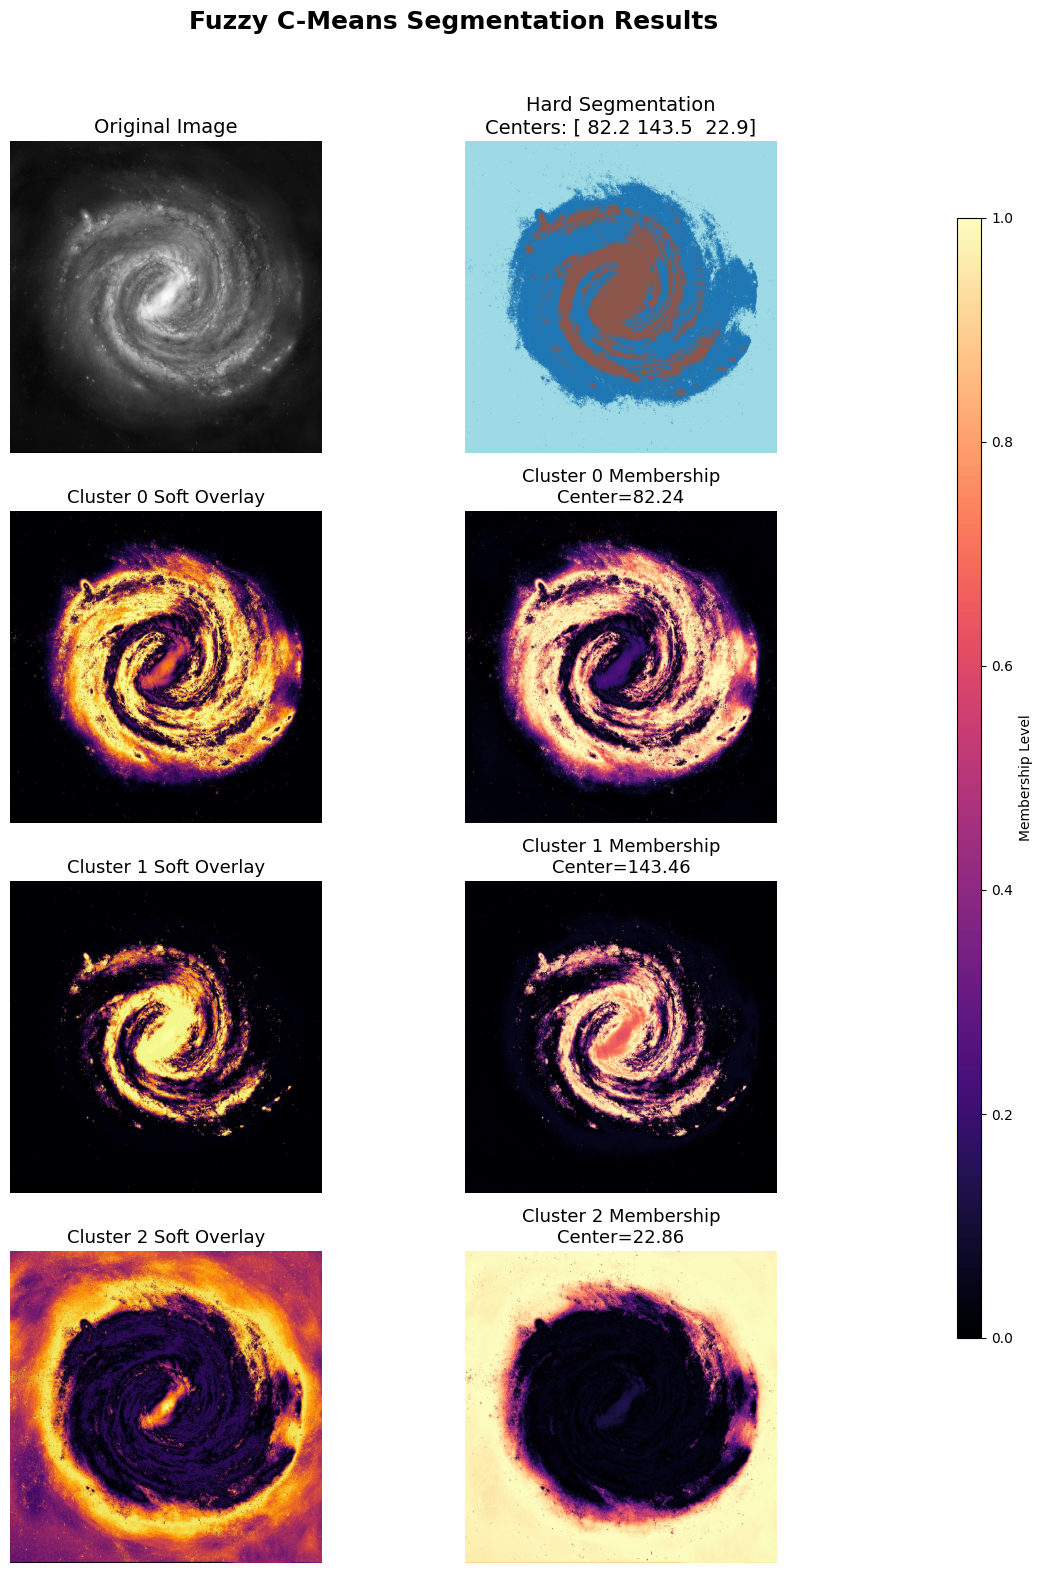

In [ ]:
show_fcm_visuals(img_array, U_out, C_out, k)


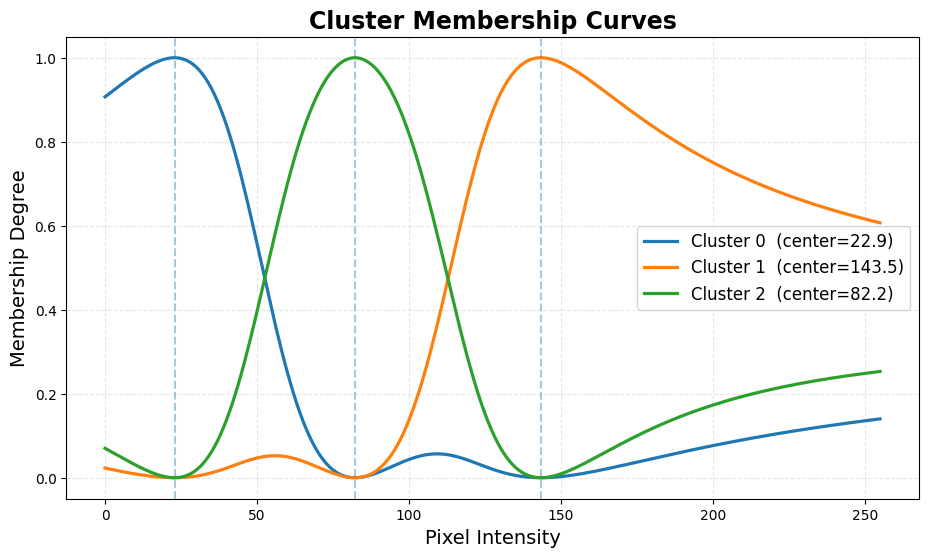

In [ ]:
plot_fuzzy_memberships(flat_pixels, U_out, C_out, k)

# RGB

In [22]:
# Load RGB
image_path2 = "/content/drive/MyDrive/milky-way.jpg"
img_rgb = cv2.imread(image_path2)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

img_array = np.array(img_rgb)

# Flatten into N × 3 vectors
points = img_array.reshape(-1, 3).astype(float)


Distance computation for RGB

In [23]:
def rgb_distance(p, c):
    return np.linalg.norm(p - c)


Membership Update for RGB

In [24]:
def refresh_memberships_rgb(U_matrix, data, centers, num_clusters, fuzziness):
    expo = 2.0 / (fuzziness - 1)

    for i in range(len(data)):
        for c in range(num_clusters):

            dist_j = rgb_distance(data[i], centers[c])

            if dist_j == 0:
                U_matrix[i, :] = 0
                U_matrix[i, c] = 1
                continue

            denom = 0
            for ck in range(num_clusters):
                dist_k = rgb_distance(data[i], centers[ck])
                if dist_k == 0:
                    ratio = np.inf
                else:
                    ratio = (dist_j / dist_k) ** expo
                denom += ratio

            U_matrix[i, c] = 1.0 / denom

    return U_matrix


Centroid Computation for RGB

In [25]:
def compute_centroids_rgb(U_matrix, data, num_clusters, fuzziness):
    centers = np.zeros((num_clusters, 3))  # RGB centroids

    for c in range(num_clusters):
        w = U_matrix[:, c] ** fuzziness
        numerator = np.sum((w[:, None] * data), axis=0)
        denominator = np.sum(w)
        centers[c] = numerator / denominator

    return centers


FCM Wrapper

In [26]:
def fuzzy_c_means_rgb(data, U_init, num_clusters, fuzziness=2, max_steps=100, epsilon=1e-4):
    U_current = U_init.copy()

    for step in range(max_steps):
        U_prev = U_current.copy()

        centers = compute_centroids_rgb(U_current, data, num_clusters, fuzziness)
        U_current = refresh_memberships_rgb(U_current, data, centers, num_clusters, fuzziness)

        if np.max(np.abs(U_current - U_prev)) < epsilon:
            print(f"Converged at iteration {step}")
            break

    return U_current, centers


Outputs


In [27]:
labels = np.argmax(U_out, axis=1).reshape(img_array.shape[:2])


Visualisations

In [28]:
def show_rgb_segmentation(img_array, memberships, centers, num_clusters):
    labels = np.argmax(memberships, axis=1)
    seg_img = centers[labels].reshape(img_array.shape).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original RGB Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(seg_img)
    plt.title("RGB Segmented Image")
    plt.axis("off")

    plt.show()


Execution

Converged at iteration 43


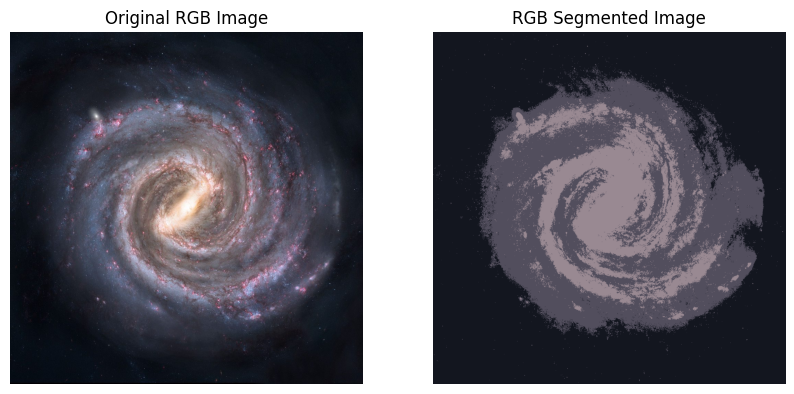

In [29]:
# Load RGB image
image_path2 = "/content/drive/MyDrive/milky-way.jpg"
img_rgb = cv2.imread(image_path2)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

img_array = np.array(img_rgb)
points = img_array.reshape(-1, 3).astype(float)

k = 3
m = 2

# Initialize membership
U0 = np.random.rand(points.shape[0], k)
U0 = U0 / U0.sum(axis=1, keepdims=True)

# Run RGB FCM
U_out, C_out = fuzzy_c_means_rgb(points, U0, k, fuzziness=m)

# Show result
show_rgb_segmentation(img_array, U_out, C_out, k)


Complex Membership Visualisation for RGB

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_membership_3d(data, membership_matrix, cluster_index=0, sample_size=5000):
    """
    3D visualization of membership for a given cluster in RGB space.

    Parameters:
    - data: (num_pixels, 3) RGB pixel values
    - membership_matrix: (num_pixels, num_clusters) FCM memberships
    - cluster_index: which cluster to visualize
    - sample_size: number of pixels to plot (for speed)
    """
    # Sample a subset for faster plotting
    if len(data) > sample_size:
        idx = np.random.choice(len(data), sample_size, replace=False)
        data_sample = data[idx]
        memberships_sample = membership_matrix[idx, cluster_index]
    else:
        data_sample = data
        memberships_sample = membership_matrix[:, cluster_index]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"3D Membership Visualization: Cluster {cluster_index}", fontsize=14)

    # Plot points with membership as color
    p = ax.scatter(data_sample[:, 0],  # R
                   data_sample[:, 1],  # G
                   data_sample[:, 2],  # B
                   c=memberships_sample,
                   cmap='viridis',
                   s=15,
                   alpha=0.6)

    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    fig.colorbar(p, ax=ax, label='Membership Degree')

    plt.show()


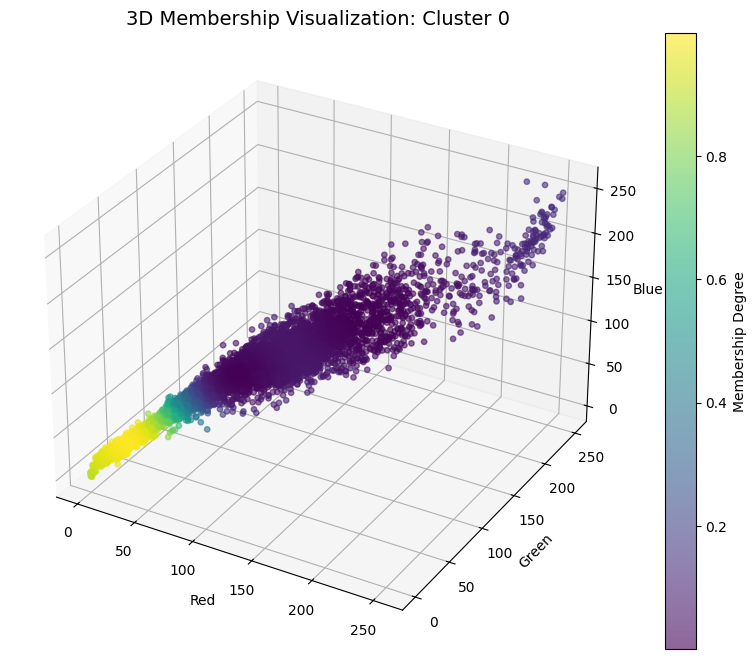

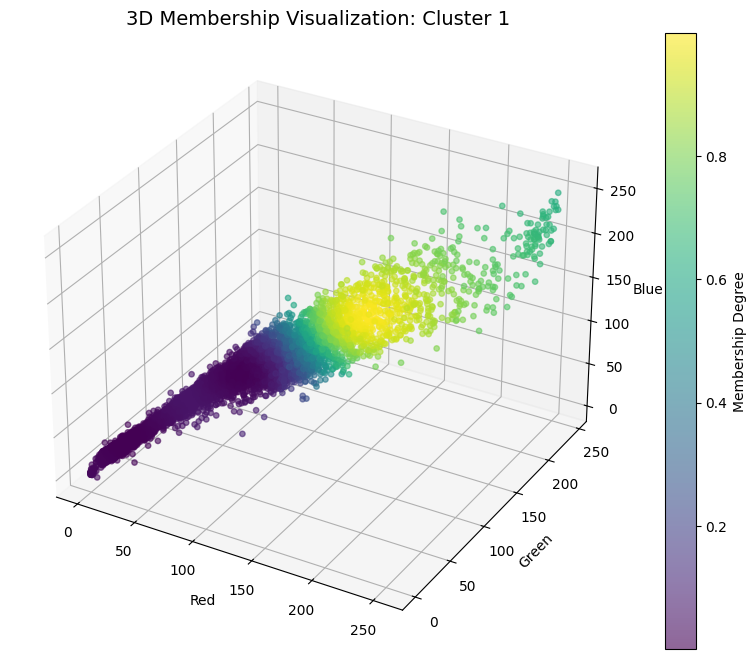

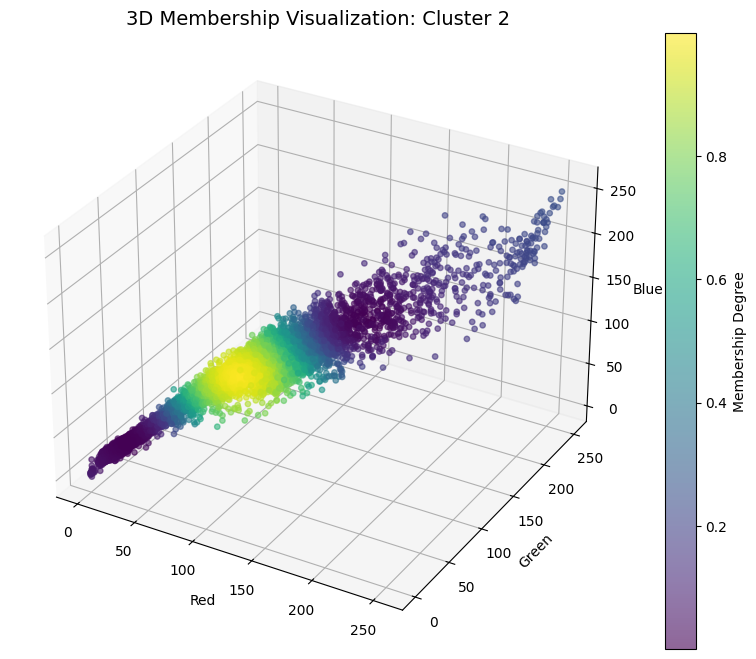

In [31]:
for c in range(k):
    plot_membership_3d(points, U_out, cluster_index=c, sample_size=10000)
